# S&P 500 Stock Classification Model

## Author: Swami Venkatesan
## Date: Oct 19, 2023

In [43]:
# Import Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import os
import matplotlib

from tslearn.clustering import TimeSeriesKMeans
from catboost import CatBoostClassifier
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


## Get Stock Information

In [4]:
sp500_download_url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv'
df_sp500 = pd.read_csv(sp500_download_url)
df_sp500_weights = pd.read_csv('./data/SP500_weightage.csv')
stock_weightage = df_sp500_weights.set_index('Symbol')['Portfolio%'].to_dict()
df_sp500['Symbol'] = df_sp500['Symbol'].str.replace('.','-')
sector_dict = df_sp500.set_index('Symbol')['GICS Sector'].to_dict()
sub_sector_dict = df_sp500.set_index('Symbol')['GICS Sub-Industry'].to_dict()
ticker_list = list(sector_dict.keys())
ticker_list.append('^GSPC')
df_sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [9]:
# Function to get the first and last price for each ticker and calculate the percentage change in the price
def fmax(df):
    #Getting the first day and last day SMA_10 stock price
    df['first_price'] =  df.sort_values(['Date']).head(1)['SMA_15'].squeeze()
    df['last_price'] = df.sort_values(['Date']).tail(1)['SMA_15'].squeeze()
    # Calculating the percentage change between the latest price and price 2y before
    df['pct_change'] =  (df['last_price'] - df['first_price'])*100/(df['first_price'])
    
    # Calculating the daily and monthly price and volume volatility
    df['avg_monthly_volatility'] = df.groupby( pd.Grouper(key = 'Date', freq='M'))['daily_avg_price'].std().mean()
    df['daily_volatility'] = df['daily_avg_price'].std()

    df = df.reset_index()
    df = df.drop_duplicates(subset = ['Ticker'])
    df = df[['Ticker','first_price', 'last_price','pct_change','daily_volatility','avg_monthly_volatility']]
    return df

In [17]:
def get_stock_performance(tickers,period='2y', save = False):
    """
    tickers: list of ticker symbols for which 2 year data needs to be queried
    period: time period
    Returns:
    dataframe: columns - stocks, 
    """
    op_path = './data/'
    today = str(datetime.datetime.today().date())
    fname = f'{op_path}SP500_{period}_stock_data_{today}.csv'
    if os.path.exists(fname):
        data_prep = pd.read_csv(fname)
        data_prep['Date'] = pd.to_datetime(data_prep['Date'])
        
    else:
        stock_2y_data = yf.Tickers(' '.join(tickers)).history(period)
        null_cols_sum = stock_2y_data.isna().sum()
        null_cols = null_cols_sum[null_cols_sum == len(stock_2y_data)].index
        
        ### Sometimes Yahoo Finance API does not return data for all stocks. 
        non_null_cols = [col for col in stock_2y_data.columns if col not in null_cols]
        stock_2y_data = stock_2y_data[non_null_cols]
        null_tickers = list(set([col[1] for col in null_cols]))

        ## Redownload stock data
        if len(null_tickers) > 0:
            if len(null_tickers) ==1:
                redown_stock_2y_data = yf.Ticker(' '.join(null_tickers)).history(period)
            else:
                redown_stock_2y_data = yf.Tickers(' '.join(null_tickers)).history(period)
            stock_2y_data = pd.concat([stock_2y_data,redown_stock_2y_data ], axis=1)
            
        ### Only choose Open and Close prices
        sel_cols = [col for col in stock_2y_data.columns if 'High' in col or 'Low' in col]
        data_prep = stock_2y_data[sel_cols].unstack().reset_index()
        data_prep = data_prep.rename(columns = {'level_0':'type','level_1':'ticker', 0:'value', 'Date':'date'})
        data_prep = data_prep.pivot(index = ['ticker', 'date'], columns = ['type'], values = ['value']).reset_index()
        data_prep.columns = data_prep.columns.droplevel()
        data_prep.columns = ['Ticker', 'Date', 'Close', 'Open']
        
        # Average Price between High and Low
        data_prep['daily_avg_price'] = (data_prep['High']  + data_prep['Low'])/2
        data_prep = data_prep.dropna()
        data_prep = data_prep.sort_values(['Ticker', 'Date'])
        
        # Calculate Simple Moving Average (SMA) for 15 days
        data_prep['SMA_15'] = data_prep.groupby('Ticker')['daily_avg_price'].rolling(15, min_periods=1, center = True).mean().values
    
    stock_performance = data_prep.groupby(['Ticker']).apply(fmax).reset_index(drop=True)
    stock_performance['Sector'] = stock_performance['Ticker'].map(sector_dict)
    stock_performance['Sub_Sector'] = stock_performance['Ticker'].map(sub_sector_dict)
    stock_performance['Stock_Weight'] = stock_performance['Ticker'].map(stock_weightage)
    performance_labels = ["decline-high", 'decline-low',  "flat", "up- low", 'up-high']
    stock_performance['performance_label'] = pd.qcut(stock_performance['pct_change'], 
                                                     5, labels=performance_labels)
    stock_performance['performance_label'] = pd.Categorical(stock_performance['performance_label'], 
                          categories=performance_labels,
                          ordered=True)
    stock_performance = stock_performance.join(df_company_info.set_index('Ticker'), on='Ticker', how = 'inner')
    # Calculate 
    data_prep['pct_change_day1'] = data_prep.groupby('Ticker').SMA_15.apply(lambda x: (x - x.iloc[0])*100/x.iloc[0]).values
    data_prep['Sector'] = data_prep['Ticker'].map(sector_dict)
    data_prep['Stock_Weight'] = data_prep['Ticker'].map(stock_weightage)
    mm = MinMaxScaler()
    data_prep['mean_scaled'] =  data_prep[['Ticker', 'SMA_15']].groupby('Ticker').transform(lambda x: mm.fit_transform(x.values[:,np.newaxis]).ravel())
        
    if save:
        os.makedirs(op_path, exist_ok=True)
        data_prep.to_csv(fname, index=False)
    return data_prep, stock_performance

In [18]:
df_company_info = pd.read_csv('./data/company_info.csv')
df_company_info = df_company_info[['Ticker','country','sector','fullTimeEmployees']]

In [19]:
stock_data,stock_performance = get_stock_performance(tickers=ticker_list, save= True)

In [20]:
stock_series = stock_data[['Date','Ticker','mean_scaled']].pivot(columns = ['Ticker'], index='Date', values = ['mean_scaled'])
null_X = stock_series.isna().sum()
null_columns = list(null_X[null_X>0].index.droplevel())
stock_series.columns = [col[1] for col in stock_series.columns]
non_null_cols = [col for col in stock_series.columns if col not in null_columns]
stock_series = stock_series[non_null_cols]
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", n_jobs=-1, max_iter=200,random_state=1234)
labels = km.fit_predict(stock_series.T.values)

<Figure size 640x480 with 0 Axes>

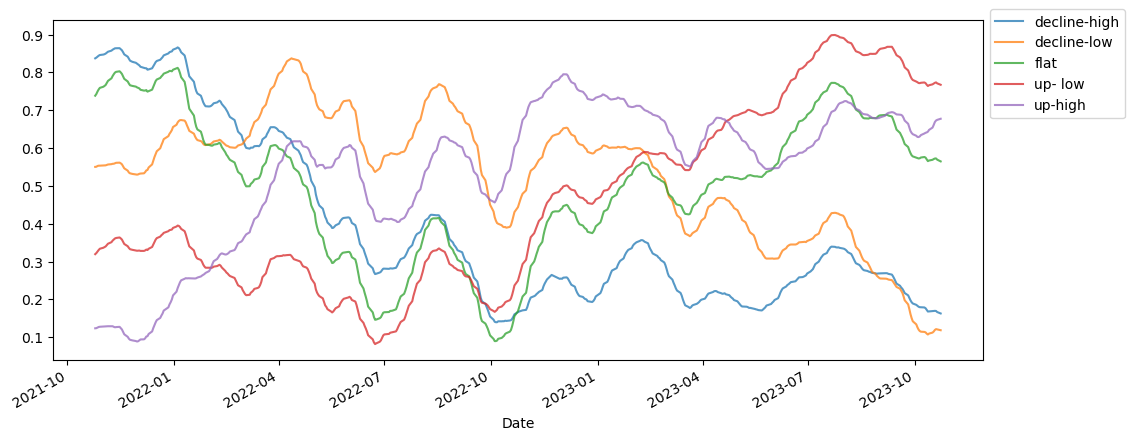

In [29]:
performance_labels = ["decline-high", 'decline-low',  "flat", "up- low", 'up-high']

df_clusters = pd.DataFrame(km.cluster_centers_.reshape(5,stock_series.T.values.shape[1]).T)
final_val = list((df_clusters.iloc[-1] - df_clusters.iloc[0])/df_clusters.iloc[0])
idx_label = {final_val.index(fv):pl for pl,fv in zip(performance_labels ,sorted(final_val))}
stock_label_dict = {k:idx_label[v] for k,v in zip(stock_series.T.index, labels)}
stock_performance['cluster_labels'] = stock_performance['Ticker'].map(stock_label_dict)

plt.figure()
df_clusters.columns = [idx_label[col] for col in df_clusters.columns]
df_clusters = df_clusters[performance_labels]
df_clusters.index = pd.to_datetime(stock_series.index)
df_clusters.plot(alpha=0.75,figsize = (12,5))
plt.legend(bbox_to_anchor=(1, 1.05))

In [30]:
dataset = stock_performance.dropna()
clus_acc = accuracy_score(dataset['performance_label'],dataset['cluster_labels'])
print(f'The Accuracy of Clustering Model is {clus_acc:0.2f}')

The Accuracy of Clustering Model is 0.45


## Gradient Boosted Tree (GBT) Model using Clustering Labels

In [49]:
dataset = stock_performance.dropna()
dataset = dataset[['daily_volatility','avg_monthly_volatility','Stock_Weight','country','Sector',
                             'Sub_Sector','fullTimeEmployees','cluster_labels','performance_label']]

X, y = dataset.drop(columns = ['performance_label']),dataset['performance_label']
X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=0.2, random_state=42)

In [51]:

cat_features = ['Sector']
cat_index = [3,4,5,7]
catboost_clf = CatBoostClassifier(task_type='CPU', eval_metric='Accuracy',cat_features=cat_index,verbose = 0, depth=8, iterations=200)
catboost_clf.fit(X_train,y_train)
y_pred =catboost_clf.predict(X_test)

print(f'The Accuracy of Clustering  + GBT Model on Test Dataset is {accuracy_score(y_test,y_pred):0.2f}')

The Accuracy of Clustering  + GBT Model on Test Dataset is 0.62


In [52]:
dataset['pred_labels'] = catboost_clf.predict(X).flatten()
clus_cb_acc =accuracy_score(y,dataset['pred_labels'] )
print(f'The Accuracy of Clustering  + GBT Model on Full Dataset is {clus_cb_acc:0.2f}')

The Accuracy of Clustering  + GBT Model on Full Dataset is 0.74


In [60]:
print(classification_report(y, dataset['cluster_labels'], target_names=performance_labels))
print(classification_report(y, dataset['pred_labels'], target_names=performance_labels))


              precision    recall  f1-score   support

decline-high       0.50      0.73      0.59       101
 decline-low       0.23      0.18      0.20        99
        flat       0.43      0.46      0.45        97
     up- low       0.38      0.33      0.35        99
     up-high       0.64      0.51      0.57        96

    accuracy                           0.45       492
   macro avg       0.44      0.44      0.43       492
weighted avg       0.44      0.45      0.43       492

              precision    recall  f1-score   support

decline-high       0.80      0.77      0.78       101
 decline-low       0.67      0.66      0.66        99
        flat       0.67      0.72      0.70        97
     up- low       0.74      0.64      0.68        99
     up-high       0.81      0.92      0.86        96

    accuracy                           0.74       492
   macro avg       0.74      0.74      0.74       492
weighted avg       0.74      0.74      0.74       492



### Feature Importance

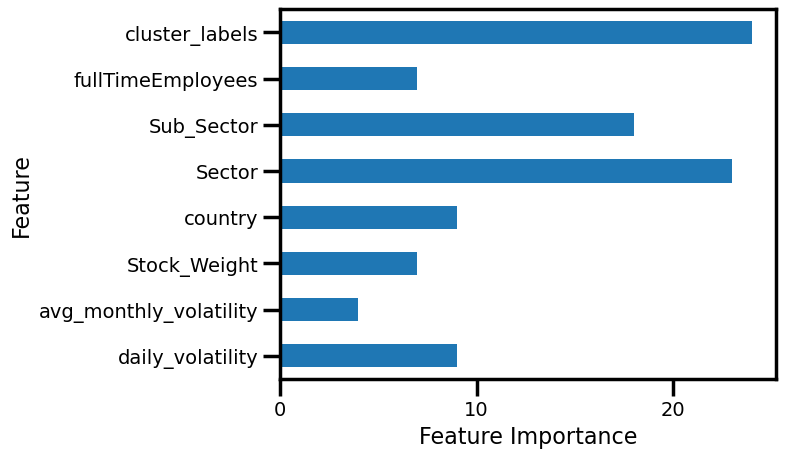

In [39]:
df_cb_feat_imp = pd.DataFrame({'Feature_Name':catboost_clf.feature_names_, 'Catboost_Feature_Importance':catboost_clf.feature_importances_})
df_cb_feat_imp.round(0).set_index('Feature_Name').plot(kind='barh', legend=False)
plt.ylabel('Feature', fontsize = 16 )
plt.xlabel('Feature Importance', fontsize = 16 )
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [35]:

def plot_heatmap_mat(y_test,pred,classes,normalize=False ):
    sns.set_context("poster", rc={"font.size":12})   
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',vmax=1, vmin=0,
                    linewidths=.5)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylabel('Actual label', fontsize = 15)
        plt.xlabel('Predicted label', fontsize = 15)
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',
                    linewidths=.5)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylabel('Actual label', fontsize = 15)
        plt.xlabel('Predicted label', fontsize = 15)
        return plot

### Model Comparison

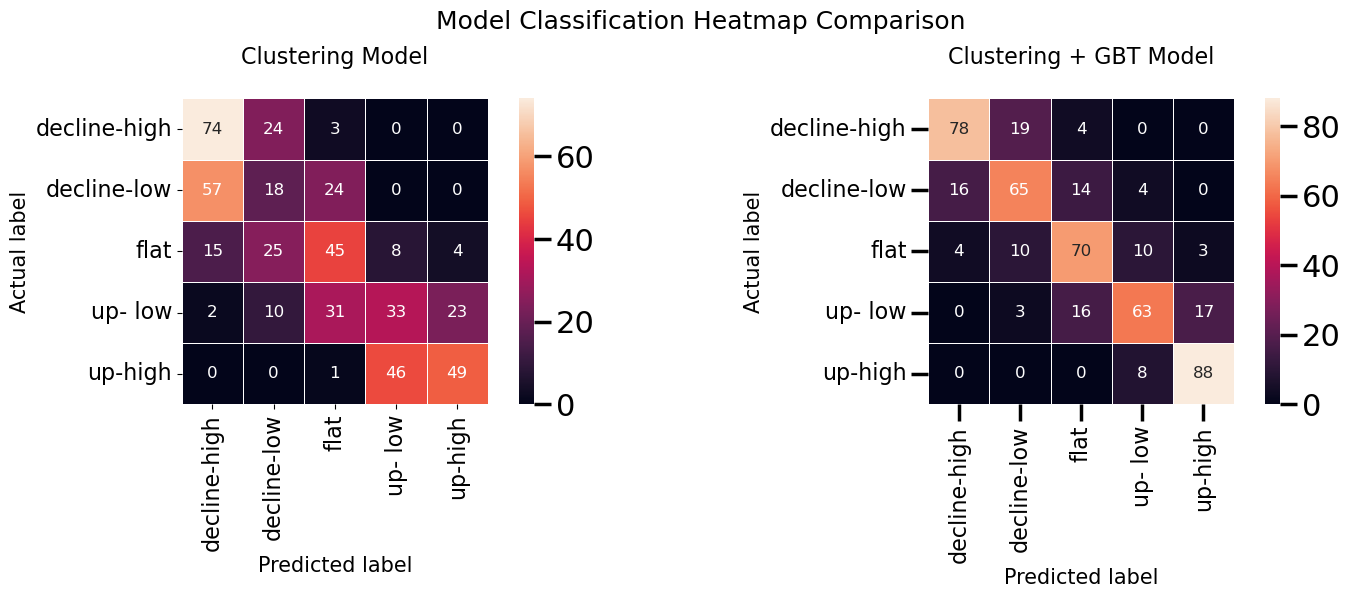

In [36]:
# Plotting the heat map of the 
fig = plt.figure(figsize=(15,10))
fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=18, x= 0.55, y =0.92)

ax1 = plt.subplot(221)
plot_heatmap_mat(y,dataset['cluster_labels'], catboost_clf.classes_,normalize=False)
ax1.set_title('Clustering Model\n', fontsize = 16)
ax2 = plt.subplot(222)
plot_heatmap_mat(y,dataset['pred_labels'], catboost_clf.classes_,normalize=False)
ax2.set_title('Clustering + GBT Model\n', fontsize = 16)

plt.tight_layout()
plt.show()

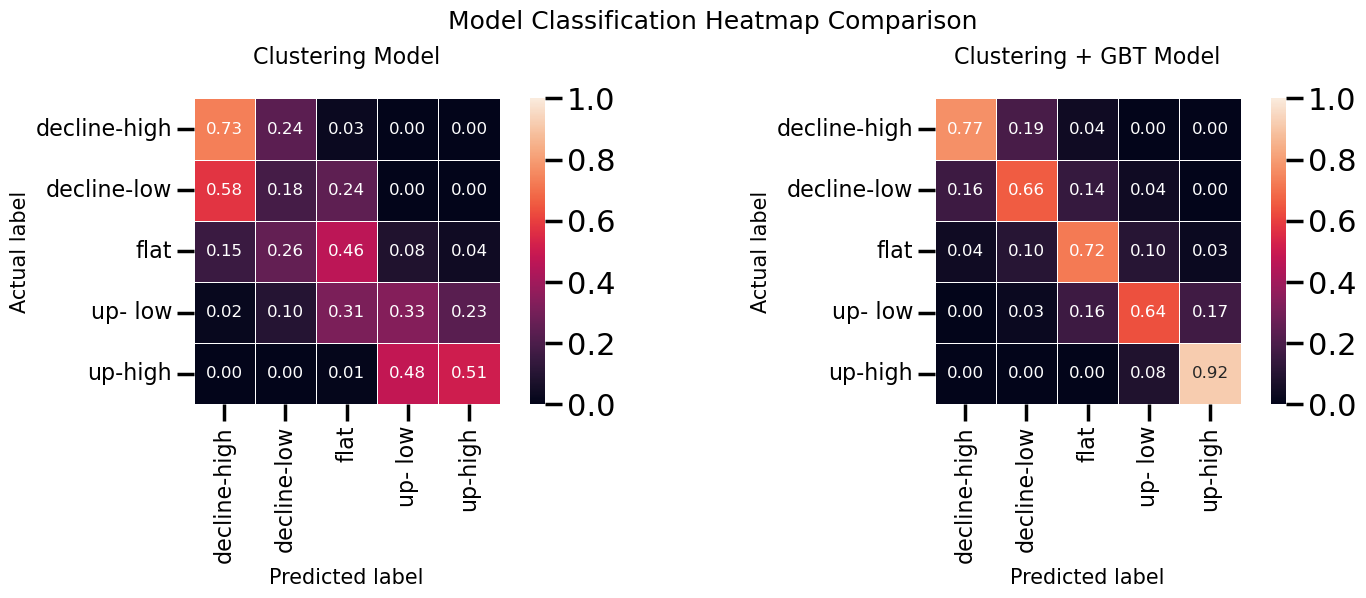

In [37]:
# Plotting the heat map of the 
fig = plt.figure(figsize=(15,10))
fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=18, x= 0.55, y =0.92)

ax1 = plt.subplot(221)
plot_heatmap_mat(y,dataset['cluster_labels'], catboost_clf.classes_,normalize=True)
ax1.set_title('Clustering Model\n', fontsize = 16)
ax2 = plt.subplot(222)
plot_heatmap_mat(y,dataset['pred_labels'], catboost_clf.classes_,normalize=True)
ax2.set_title('Clustering + GBT Model\n', fontsize = 16)

plt.tight_layout()
plt.show()